# Generating data with arbitrary latent dimensionality and correlation structure

In [1]:
import pandas as pd
import scanpy as sc
import anndata as ad
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sps
from scipy.stats import ranksums
    
import tools.util_probe as up
import tools.util as ut
import tools.NB_est as nb
import tools.countsplit as cs
import tools.ClusterDE as cd

import importlib

In [2]:
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Resources'
r_path = "/Library/Frameworks/R.framework/Resources/bin"
os.environ["PATH"] = r_path + ";" + os.environ["PATH"]

import anndata2ri
anndata2ri.activate()
%load_ext rpy2.ipython

In [3]:
import importlib

## Preprocessing template data
### Read data

In [4]:
data_gene = sc.read_h5ad("../../data/MOBA_scRNAseq/outs_S3/filtered_data_maxpool_nb_est.h5ad")


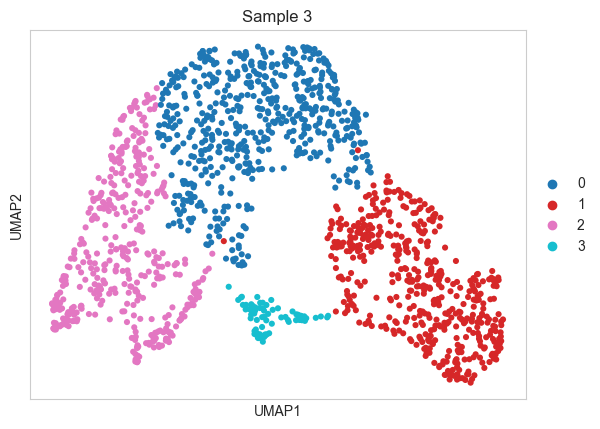

In [5]:
sc.tl.leiden(data_gene, resolution=0.15, key_added="leiden_opt", random_state=1234)
sc.pl.umap(data_gene, color="leiden_opt", palette="tab10", title="Sample 3")
plt.show()

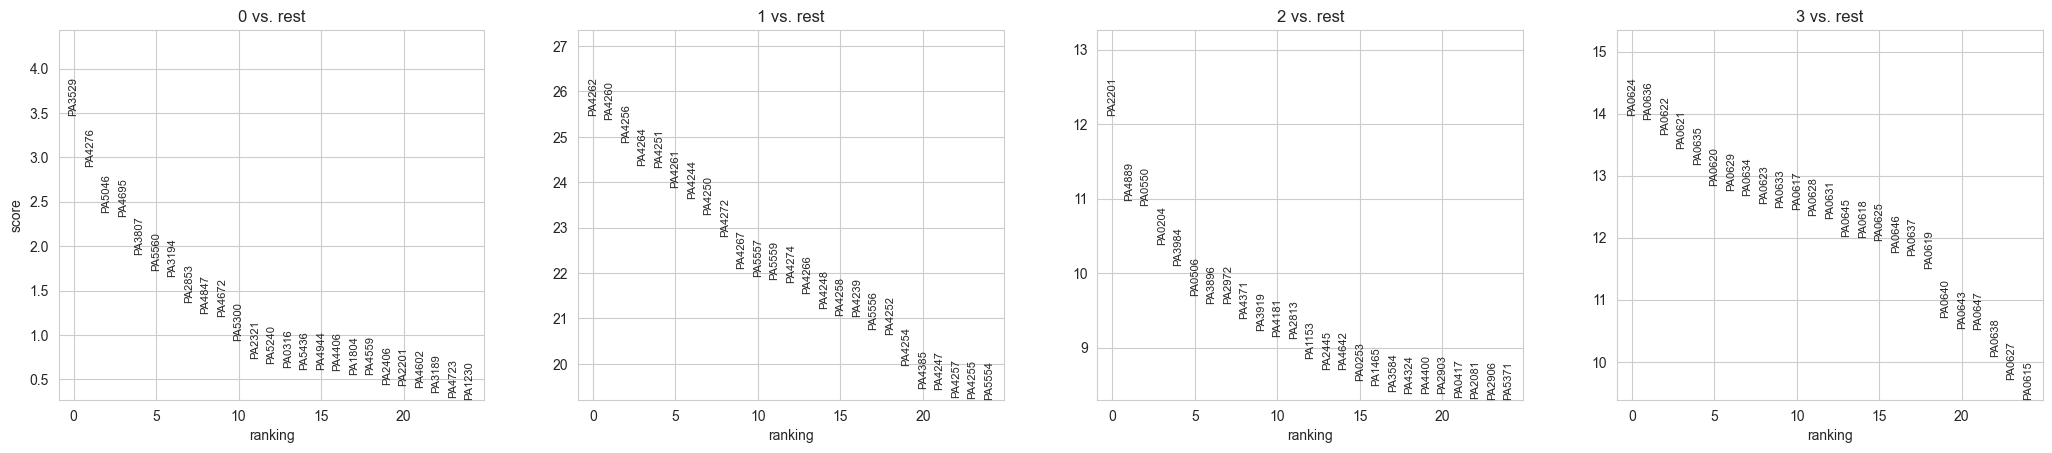

In [6]:
sc.tl.rank_genes_groups(data_gene, 'leiden_opt', method='wilcoxon')
sc.pl.rank_genes_groups(data_gene, n_genes=25, sharey=False)

## Copula, direction 1

In [7]:
from scipy.stats import norm

rng = np.random.default_rng(1234)
X = ut.convert_to_dense_counts(data_gene, layer="counts")

means = data_gene.var["est_mean"]
overdisps = data_gene.var["est_overdisp"]
zinfs = data_gene.var["est_zero_inflation"]

n, p = X.shape
new_data_shape = (n, p)

# Do counts-to-uniform transforamation from scDesign
F = np.array([cd.dist_cdf_selector(X[:, j], means[j], overdisps[j], zinfs[j]) for j in range(p)]).T
F1 = np.array([cd.dist_cdf_selector(X[:, j] + 1, means[j], overdisps[j], zinfs[j]) for j in range(p)]).T

V = rng.uniform(0, 1, F.shape)
U = V * F + (1 - V) * F1
U[U == 1] = 0.99999

# Gaussian Copula
U_inv = norm.ppf(U, 0, 1)

# Estimate correlation matrix
R_est = np.corrcoef(U_inv.T)

# R_est = np.cov(U_inv.T)
# R_est[R_est < 0] = 0
# R_est = np.nan_to_num(R_est, nan=0, posinf=1, neginf=-1)

Estimated correlation matrix

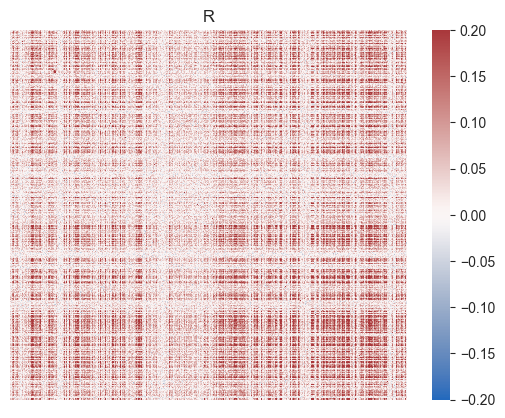

In [8]:
sns.heatmap(R_est,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R")
plt.show()

Generate similar correlation matrix, but with low rank

--> Easiest Way: rank-k SVD of R_est

In [9]:
U, S, V = np.linalg.svd(R_est)

In [30]:
k = 5
S_ = S
S_[k:] = 0

R_new = U @ np.diag(S_) @ V

var_factor = 2
np.fill_diagonal(R_new, R_new.diagonal() * var_factor)

print(R_new.shape)

(5553, 5553)


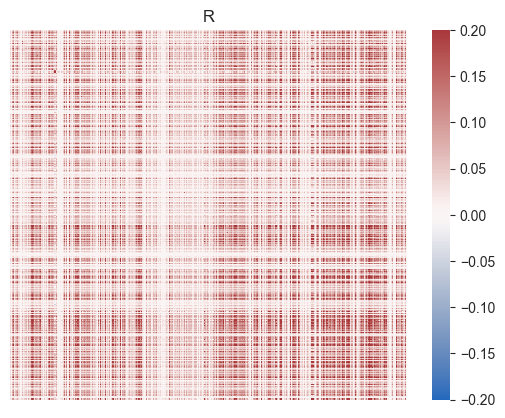

In [31]:
sns.heatmap(R_new,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("R")
plt.show()

### Generate new data

In [ ]:
Z = rng.multivariate_normal(mean=np.zeros(new_data_shape[1]), cov=R_new, size=new_data_shape[0])
Z_cdf = norm.cdf(Z)
Y_gen = np.array([cd.dist_ppf_selector(Z_cdf[:, j], means[j], overdisps[j], zinfs[j]) for j in
                  range(new_data_shape[1])]).T

# Make return anndata object
data_new_gen = ad.AnnData(X=Y_gen)
if new_data_shape == X.shape:
    data_new_gen.obs = pd.DataFrame(index=data_gene.obs.index)
    data_new_gen.var = pd.DataFrame(index=data_gene.var.index)

In [ ]:
sc.pp.calculate_qc_metrics(data_new_gen)
data_new_gen.var["var_counts"] = np.asarray(np.var(data_new_gen.X, axis=0)).squeeze()
data_new_gen.var["mean_counts"] = np.asarray(np.mean(data_new_gen.X, axis=0)).squeeze()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="mean_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene mean counts")
sns.histplot(data_new_gen.var, x="mean_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene mean counts")

mean_df = pd.DataFrame({"original_means": data_new_gen.var["mean_counts"], "null_means": data_gene.var["mean_counts"]})
sns.scatterplot(mean_df, y="null_means", x="original_means", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["mean_counts"]))], [0, np.ceil(np.max(data_gene.var["mean_counts"]))], color="red")
ax[2].set_title("Gene mean comparison")
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12,3))
sns.histplot(data_gene.var, x="var_counts", ax=ax[0], log_scale=True)
ax[0].set_title("Original data gene variances")
sns.histplot(data_new_gen.var, x="var_counts", ax=ax[1], log_scale=True)
ax[1].set_title("Null data gene variances")

var_df = pd.DataFrame({"original_vars": data_gene.var["var_counts"], "null_vars": data_new_gen.var["var_counts"]})
var_df["ratio"] = var_df["null_vars"] / var_df["original_vars"]
sns.scatterplot(var_df, y="null_vars", x="original_vars", ax=ax[2])
ax[2].plot([0, np.ceil(np.max(data_gene.var["var_counts"]))], [0, np.ceil(np.max(data_gene.var["var_counts"]))], color="red")
ax[2].set_title("Gene variance comparison")
plt.tight_layout()
plt.show()

sns.scatterplot(var_df, x="original_vars", y="ratio")
plt.show()

In [ ]:
cor_orig = np.corrcoef(data_gene.layers["counts"].toarray().T)
cor_orig = pd.DataFrame(cor_orig, index=data_gene.var_names, columns=data_gene.var_names)

cor_gen = np.corrcoef(data_new_gen.X.T)
cor_gen = pd.DataFrame(cor_gen, index=data_gene.var_names, columns=data_gene.var_names)

sns.heatmap(cor_orig,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Original data")
plt.show()

sns.heatmap(cor_gen,
            cmap='vlag', vmin=-0.2, vmax=0.2, center=0,
            xticklabels=False, yticklabels=False)
plt.title("Gene-gene correlation - Null data")
plt.show()

In [ ]:
# Plot only 100.000 randomly sampled correlations instaed of ~30M
rng = np.random.default_rng(1234)
all_cors = pd.DataFrame({"cor_orig": cor_orig.values.flatten(), "cor_gen": cor_gen.values.flatten(), "cor_null": cor_gen.values.flatten()})

ids = rng.choice(len(all_cors), 100000, replace=False)
all_cors_subset = all_cors.loc[ids]

sns.scatterplot(all_cors_subset[all_cors_subset['cor_orig'] < 0.99], x="cor_orig", y="cor_gen", s=1, color="black")
plt.plot([0, np.ceil(np.max(all_cors_subset['cor_orig']))], [0, np.ceil(np.max(all_cors_subset['cor_orig']))], color="red")
plt.show()

### SVD of generated counts

In [18]:
U_gen, S_gen, V_gen = np.linalg.svd(data_new_gen.X)


<Axes: >

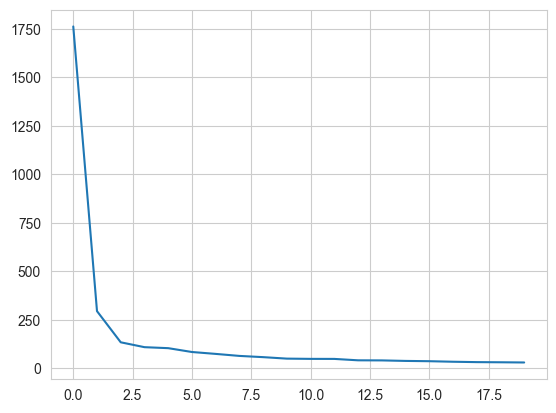

In [19]:
sns.lineplot(S_gen[:20])

### Processing and dimensionality check

In [20]:
data_new_gen.layers["counts"] = data_new_gen.X.copy()
nb.estimate_overdisp_nb(data_new_gen, flavor="statsmod_auto", layer="counts")

gene 0
gene 100
gene 200
gene 300
gene 400
gene 500
gene 600
gene 700
gene 800
gene 900
gene 1000
gene 1100
gene 1200
gene 1300
gene 1400
gene 1500
gene 1600
gene 1700
gene 1800
gene 1900
gene 2000
gene 2100
gene 2200
gene 2300
gene 2400
gene 2500
gene 2600
gene 2700
gene 2800
gene 2900
gene 3000
gene 3100
gene 3200
gene 3300
gene 3400
gene 3500
gene 3600
gene 3700
gene 3800
gene 3900
gene 4000
gene 4100
gene 4200
gene 4300
gene 4400
gene 4500
gene 4600
gene 4700
gene 4800
gene 4900
gene 5000
gene 5100
gene 5200
gene 5300
gene 5400
gene 5500


In [21]:
data_new_gen.var["nb_overdisp"] = np.nan_to_num(data_new_gen.var["est_overdisp"], posinf=1e-3)
data_new_gen.var["nb_mean"] = np.nan_to_num(data_new_gen.var["est_mean"], posinf=1e-3)


In [22]:
data_new_gen.X = data_new_gen.layers["counts"].copy()

In [23]:
k_opt = 3
n_neighbors_opt = 50
min_dist_opt = 0.3
res_opt = 0.15

sc.pp.calculate_qc_metrics(data_new_gen, var_type="genes", percent_top=None, log1p=True, inplace=True)
data_new_gen.layers["counts"] = data_new_gen.X.copy()
sc.pp.normalize_total(data_new_gen, target_sum=None, layer=None)
data_new_gen.X = sps.csr_matrix(np.log(data_new_gen.X + np.array(data_new_gen.var["nb_overdisp"] / 4)))
data_new_gen.layers["vst_counts"] = data_new_gen.X.copy()
sc.pp.scale(data_new_gen, max_value=10, zero_center=True)
data_new_gen.X[np.isnan(data_new_gen.X)] = 0

In [24]:
data_new_gen.var["gene_dist"].value_counts()

gene_dist
poi    5442
nb      111
Name: count, dtype: int64

In [25]:
data_new_gen.var

,var_counts,mean_counts,gene_mean,gene_var,mean_var_diff,gene_dist,est_mean,est_overdisp,est_zero_inflation,nb_overdisp,nb_mean,n_cells_by_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,mean,std
PAO1_ID,,,,,,,,,,,,,,,,,,
PA0001,0.299699,0.454016,0.454016,0.299699,0.154317,poi,0.454016,inf,0.0,0.001000,0.454016,662,0.374329,57.124352,701.0,6.553933,-5.028211,3.784611
PA0002,0.163964,0.200130,0.200130,0.163964,0.036166,poi,0.200130,inf,0.0,0.001000,0.200130,306,0.182429,80.181347,309.0,5.736572,-6.840202,2.934731
PA0003,0.401671,0.715674,0.715674,0.401671,0.314002,poi,0.715674,inf,0.0,0.001000,0.715674,960,0.539806,37.823834,1105.0,7.008505,-3.373466,3.858850
PA0004,0.108721,0.122409,0.122409,0.108721,0.013689,poi,0.122409,inf,0.0,0.001000,0.122409,188,0.115478,87.823834,189.0,5.247024,-7.437162,2.304684
PA0005,0.000000,0.000000,0.000000,0.000000,0.000000,poi,0.000000,inf,0.0,0.001000,0.000000,0,0.000000,100.000000,0.0,0.000000,-8.294050,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PA5566,0.000000,0.000000,0.000000,0.000000,0.000000,poi,0.000000,inf,0.0,0.001000,0.000000,0,0.000000,100.000000,0.0,0.000000,-8.294050,NaN
PA5567,0.000000,0.000000,0.000000,0.000000,0.000000,poi,0.000000,inf,0.0,0.001000,0.000000,0,0.000000,100.000000,0.0,0.000000,-8.294050,NaN
PA5568,0.285829,0.444948,0.444948,0.285829,0.159119,poi,0.444948,inf,0.0,0.001000,0.444948,658,0.368073,57.383420,687.0,6.533789,-5.077494,3.743090


In [26]:
# nb.estimate_overdisp_nb(data_new_gen, flavor="BFGS", layer="counts")
data_train, data_test = cs.countsplit_adata(data_new_gen, data_dist="NB", beta_key="nb_overdisp", layer="counts", min_genes=1, max_counts=1e9, seed=1234)
print(data_train)

AnnData object with n_obs × n_vars = 1512 × 1362
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'n_PCs_by_counts', 'log1p_n_PCs_by_counts'
    var: 'var_counts', 'mean_counts', 'gene_mean', 'gene_var', 'mean_var_diff', 'gene_dist', 'est_mean', 'est_overdisp', 'est_zero_inflation', 'nb_overdisp', 'nb_mean', 'n_cells_by_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std', 'n_cells'
    layers: 'counts'


In [27]:
# Transformation, centering and PCA
sc.pp.normalize_total(data_train, target_sum=None, layer=None)
data_train.X = sps.csr_matrix(np.log(data_train.X.toarray() + np.array(data_train.var["nb_overdisp"] / 4)))
data_train.layers["vst_counts"] = data_train.X.copy()
sc.pp.scale(data_train, max_value=10, zero_center=True)
sc.tl.pca(data_train, svd_solver='arpack')


sc.pp.normalize_total(data_test, target_sum=None, layer=None)
data_test.X = sps.csr_matrix(np.log(data_test.X.toarray() + np.array(data_test.var["nb_overdisp"] / 4)))
data_test.layers["vst_counts"] = data_test.X.copy()
sc.pp.scale(data_test, max_value=10, zero_center=True)
sc.tl.pca(data_test, svd_solver='arpack')

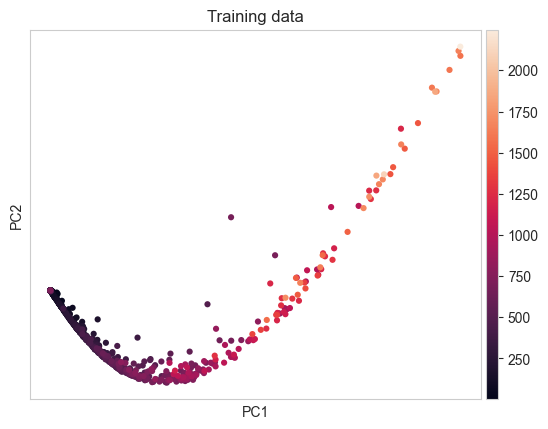

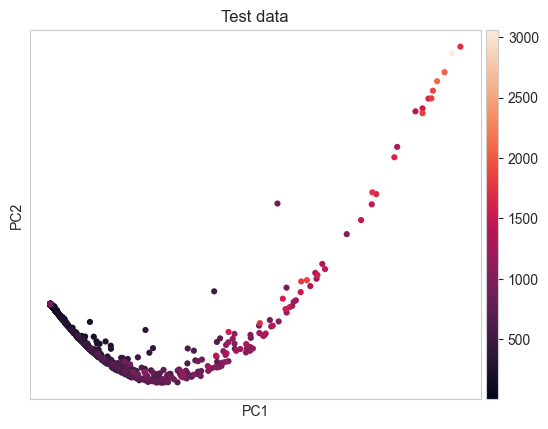

In [28]:
sc.pl.pca(data_train, title="Training data", color="total_counts")
plt.show()

sc.pl.pca(data_test, title="Test data", color="total_counts")
plt.show()

Optimal number of PCs:1


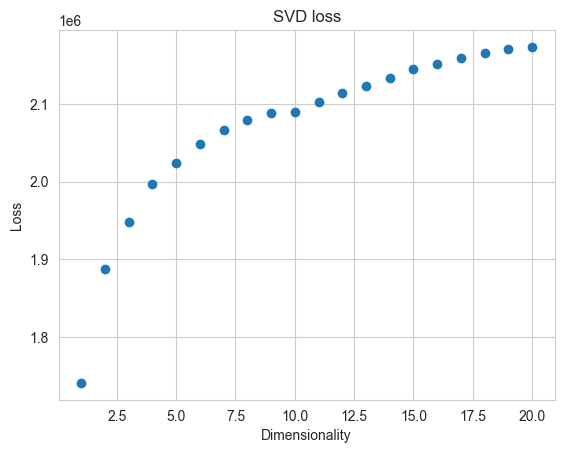

In [29]:
k_errors, k_opt = cs.select_n_pcs_countsplit(data_train, data_test)
print(f"Optimal number of PCs:{k_opt}")

plt.scatter(np.arange(20) + 1, k_errors)
plt.title("SVD loss")
plt.xlabel("Dimensionality")
plt.ylabel("Loss")
plt.show()